In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures


import requests
from bs4 import BeautifulSoup


In [66]:
min_year = 1920
max_year = 2008
degr = 3
username = "spicymcspice"

In [67]:
df = pd.read_csv("watched.csv")

In [68]:
# five number summary of df[Year]
print(df["Year"].describe())

count    1345.000000
mean     1999.100372
std        21.532531
min      1920.000000
25%      1988.000000
50%      2006.000000
75%      2015.000000
max      2024.000000
Name: Year, dtype: float64


In [69]:
# only contain rows where the year is between min and max year

df = df[(df["Year"] >= min_year) & (df["Year"] <= max_year)]

In [70]:
year_frequency = df['Year'].value_counts().reset_index()
year_frequency.columns = ['Year', 'Frequency']

# If there is a value missing from the range 1928 to 2010, enter it with 1e-10 frequency
missing_years = [{'Year': i, 'Frequency': 0} for i in range(min_year, max_year) if i not in year_frequency['Year'].values]
print(missing_years)
missing_years_df = pd.DataFrame(missing_years)
year_frequency = pd.concat([year_frequency, missing_years_df]).sort_values('Year').reset_index(drop=True)

# Separate the features and the target variable
X = year_frequency['Year'].values.reshape(-1, 1)
y = year_frequency['Frequency'].values

print(year_frequency)

[{'Year': 1923, 'Frequency': 0}, {'Year': 1926, 'Frequency': 0}, {'Year': 1929, 'Frequency': 0}]
    Year  Frequency
0   1920          1
1   1921          1
2   1922          1
3   1923          0
4   1924          1
..   ...        ...
84  2004         24
85  2005         24
86  2006         26
87  2007         27
88  2008         28

[89 rows x 2 columns]


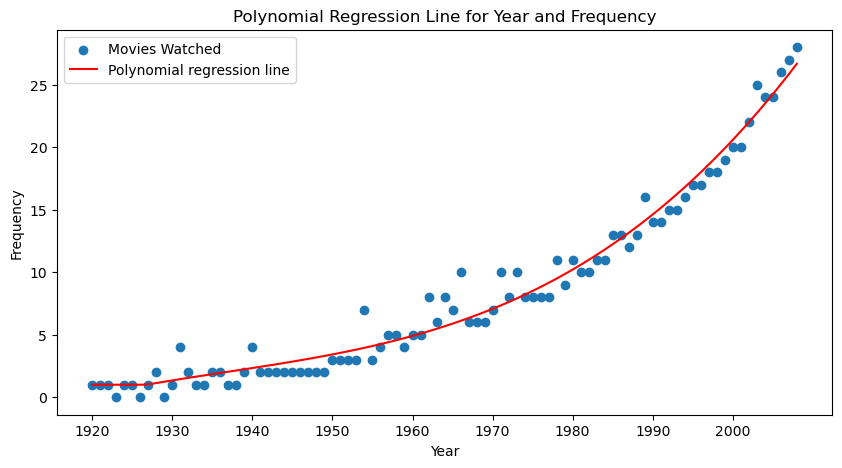

In [71]:
poly = PolynomialFeatures(degree=degr)
X_poly = poly.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)
regression_line = model.predict(X_poly)
# if the prediction is <=1, set it to 1
regression_line = np.where(regression_line <= 1, 1, regression_line)
plt.figure(figsize=(10, 5))
plt.scatter(year_frequency['Year'], year_frequency['Frequency'], label='Movies Watched')
plt.plot(year_frequency['Year'], regression_line, color='red', label='Polynomial regression line')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Polynomial Regression Line for Year and Frequency')
plt.legend()
plt.xticks(np.arange(min_year, max_year+1, 10))
plt.show()

In [72]:
predictions = regression_line
results_df = year_frequency.copy()
results_df['Exponential_Predictions'] = predictions
results_df['Residuals'] = results_df['Frequency'] - results_df['Exponential_Predictions']

results_df.head()

,Year,Frequency,Exponential_Predictions,Residuals
0,1920,1,1.0,0.0
1,1921,1,1.0,0.0
2,1922,1,1.0,0.0
3,1923,0,1.0,-1.0
4,1924,1,1.0,0.0


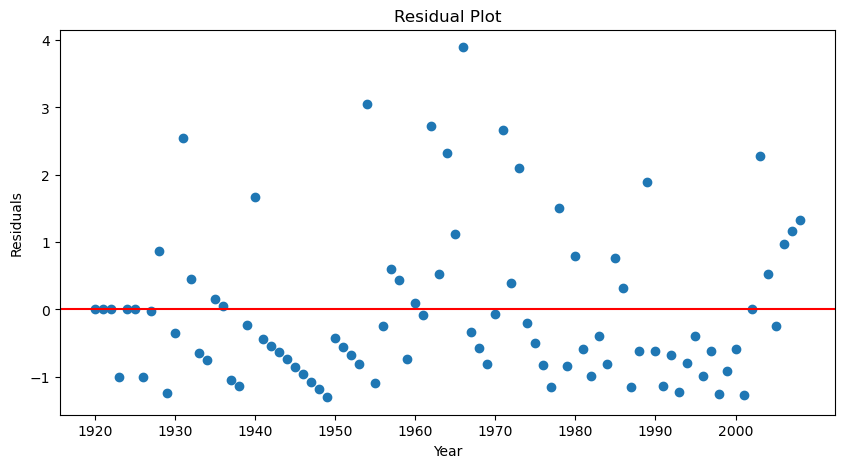

In [73]:
# residual plot
plt.figure(figsize=(10, 5))
plt.scatter(results_df['Year'], results_df['Residuals'])
plt.axhline(y=0, color='red')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.xticks(np.arange(min_year, max_year+1, 10))
plt.show()

In [74]:
equation = f'y = {model.intercept_:.4f}'
for i, coef in enumerate(model.coef_):
    equation += f' + {coef:.6f}x^{i+1}'
print(equation)

y = -353125.7867 + 0.000000x^1 + 546.847764x^2 + -0.282330x^3 + 0.000049x^4


In [75]:
results_df.to_csv('polyreg.csv', index=False)

print("Exported the exponential regression results to 'polyreg.csv'")

Exported the exponential regression results to 'polyreg.csv'


In [76]:
print(results_df.sort_values(by='Residuals').head(16))

    Year  Frequency  Exponential_Predictions  Residuals
29  1949          2                 3.303344  -1.303344
81  2001         20                21.276788  -1.276788
78  1998         18                19.251845  -1.251845
9   1929          0                 1.240441  -1.240441
73  1993         15                16.231318  -1.231318
28  1948          2                 3.185143  -1.185143
57  1977          8                 9.150514  -1.150514
67  1987         12                13.146504  -1.146504
71  1991         14                15.140336  -1.140336
18  1938          1                 2.138408  -1.138408
35  1955          3                 4.098900  -1.098900
27  1947          2                 3.070276  -1.070276
17  1937          1                 2.040848  -1.040848
3   1923          0                 1.000000  -1.000000
6   1926          0                 1.000000  -1.000000
76  1996         17                17.991936  -0.991936


In [77]:
print('Mean Squared Error:', mean_squared_error(results_df['Frequency'], results_df['Exponential_Predictions']))
print('Mean Absolute Error:', mean_absolute_error(results_df['Frequency'], results_df['Exponential_Predictions']))
print('Sum Residuals <= -.5:', results_df[results_df['Residuals'] < -.5]['Residuals'].sum())

Mean Squared Error: 1.2797973917574728
Mean Absolute Error: 0.8711587589841043
Sum Residuals <= -.5: -36.92948203103151


In [78]:
min_resid_yr = results_df.loc[results_df['Residuals'].idxmin(), 'Year']
print(f"The year with the lowest negative residual is {min_resid_yr}")
url = f'https://letterboxd.com/{username}/watchlist/year/{min_resid_yr}/by/popular/'


The year with the lowest negative residual is 1949


In [79]:

response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    # print(soup.prettify())
    ul_el = soup.find('ul', class_='poster-list')
    first_movie = ul_el.find('li')
    img = first_movie.find('img')
    img_tag = img['alt']
    print(f"The most popular movie in {min_resid_yr} from your watchlist is {img_tag}")



The most popular movie in 1949 from your watchlist is Late Spring
